In [1]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, \
    Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, MaxPool2D, GlobalAvgPool2D, \
    Reshape, Permute, Lambda, Dropout, Flatten
import tensorflow as tf

In [2]:
def stage(x, channels, repetitions, groups):
    x = shufflenet_block(x, channels, 2, groups) #strides=2 içim
    for _ in range(repetitions):
        x = shufflenet_block(x, channels, 1, groups) #strides=1 için
    return x

In [3]:
def shufflenet_block(tensor, channels, strides, groups):
    x = gconv(tensor, channels // 4, groups)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    x = DepthwiseConv2D(3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    if strides == 2:
        channels = channels - tensor.shape[-1]

    x = gconv(x, channels, groups)
    x = BatchNormalization()(x)

    if strides == 1:
        x = Add()([tensor, x])
    else:
        avg = AvgPool2D(3, strides=2, padding='same')(tensor)
        x = Concatenate()([avg, x])
    x = ReLU()(x)
    return x

In [14]:
def gconv(tensor, channels, groups):
    input_shape = tf.keras.backend.int_shape(tensor)
    input_ch = input_shape[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []

    for i in range(groups):
        #group_tensor = tensor[:, :, :, (i*group_ch): (i+1) * group_ch]
        group_tensor = Lambda(lambda x: x[:, :, :, (i*group_ch): (i+1) * group_ch], output_shape=(input_shape[1], input_shape[2], group_ch))(tensor) #lambda normalinden daha hızlı çalıştığı için hız istnen durumlarda daha çok tercih ediliyor
        group_tensor = Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)
    output = Concatenate()(groups_list)
    return output

In [15]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.shape
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [16]:
#MODELİ OLUŞTURMAYA BAŞLAYABİLİRİZ

input = Input(shape=(224, 224, 3))  #girdi olarak verilecek veri setinin sahip olması gereken boyutları ve channel sayısını belirtiyor. shufflenet girdi olarak bunu kabul ediyor.
x = Conv2D(24, 3 ,strides=2, padding='same')(input) #24 filters, 3×3 kernel size, strides 2
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(3, strides=2, padding='same')(x) #3×3 kernel size, strides 2

In [17]:
repetitions = 3, 7, 3 #stage2, stage3, stage4 #stage içerisinde her stage için zorunlu ilk adım olan strides 2'yi yaptırdığım için tekrar sayılarını normalden birer eksik verebiliyorum.
initial_channels = 128
groups = 3

for i, reps in enumerate(repetitions):
    channels = initial_channels * (2**i)
    x = stage(x, channels, reps, groups)

In [18]:
#print("Shape before GlobalAvgPool2D:", x.shape)
x = GlobalAvgPool2D()(x)
#print("Shape after GlobalAvgPool2D:", x.shape)
shuffle_output = x
print(shuffle_output.shape)

from tensorflow.keras import Model
#model1 = Model(input, output)

(None, 510)


In [19]:
model2 = tf.keras.applications.MobileNetV3Small(input_tensor=input,include_top=False, weights='imagenet', pooling='avg')
mobilenet_output = model2.output
print(mobilenet_output.shape)

(None, 576)


In [28]:
concat_output = Concatenate()([Flatten()(shuffle_output), Flatten()(model2.output)])
print(concat_output.shape)
concat_output = Dropout(0.8)(concat_output)
print(concat_output.shape)
concat_output = Dense(2, activation='softmax')(concat_output)
print(concat_output.shape)
#model = Model(inputs=[base_model2.input, base_model1.input], outputs = output)
model = Model(inputs = input, outputs = concat_output)

(None, 1086)
(None, 1086)
(None, 2)


In [36]:
#MODELİ EĞİTMEK İÇİN VERİ SETLERİNİ ALIP MODELİN İSTEDİĞİ HALE GETİRMEM LAZIM Kİ DOĞRU ÇALIŞABİLSİN --> PREPROCESSING
#Bundan sonraki adımlarda bana gerekecek olan kütüphaneleri ekliyorum

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from matplotlib import pyplot as plt

In [37]:
train_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2])   #test klasöründen çekemediğim için train verisetinden testlik bir kısım almam gerekti

train_datas = train_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 901 images belonging to 2 classes.


In [38]:
validation_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

validation_datas = validation_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/validation', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 258 images belonging to 2 classes.


In [39]:
test_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datas = test_generate.flow_from_directory(
    'datasets/realfakedataset_HARD/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Type of class labels
    shuffle=False)

Found 130 images belonging to 2 classes.


In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_97 (Conv2D)            │ (None, 112, 112, 24)      │             672 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_49        │ (None, 112, 112, 24)      │              96 │ conv2d_97[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_75 (ReLU)               │ (None, 112, 112, 24)      │               0 │ batch_normalization_49[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 24)        │               0 │ re_lu_75[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_96 (Lambda)            │ (None, 56, 56, 8)         │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_97 (Lambda)            │ (None, 56, 56, 8)         │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_98 (Lambda)            │ (None, 56, 56, 8)         │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_98 (Conv2D)            │ (None, 56, 56, 10)        │              90 │ lambda_96[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_99 (Conv2D)            │ (None, 56, 56, 10)        │              90 │ lambda_97[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_100 (Conv2D)           │ (None, 56, 56, 10)        │              90 │ lambda_98[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_35 (Concatenate)  │ (None, 56, 56, 30)        │               0 │ conv2d_98[0][0],           │
│                               │                           │                 │ conv2d_99[0][0],           │
│                               │                           │                 │ conv2d_100[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_50        │ (None, 56, 56, 30)        │             120 │ concatenate_35[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_76 (ReLU)               │ (None, 56, 56, 30)        │               0 │ batch_normalization_50[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_32 (Reshape)          │ (None, 56, 56, 10, 3)     │               

 Total params: 1,223,474 (4.67 MB)

 Trainable params: 1,198,444 (4.57 MB)

 Non-trainable params: 25,030 (97.77 KB)

In [41]:
logdir = 'shufflenet_logs_mobilewshuffle' #eğitimle ilgili logların tutulacağı bir klasör oluşturuyoruz
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
hist = model.fit(train_datas, epochs=21, validation_data=validation_datas, callbacks=[tensorboard_callback])

Epoch 1/21


C:\Users\ilayd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4951 - loss: 2.0437 - val_accuracy: 0.4574 - val_loss: 0.8119
Epoch 2/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6074 - loss: 1.5027 - val_accuracy: 0.4574 - val_loss: 0.8543
Epoch 3/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6283 - loss: 1.4546 - val_accuracy: 0.4574 - val_loss: 0.9096
Epoch 4/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7360 - loss: 0.8712 - val_accuracy: 0.4574 - val_loss: 0.9595
Epoch 5/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8082 - loss: 0.6650 - val_accuracy: 0.4574 - val_loss: 0.9982
Epoch 6/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8574 - loss: 0.5075 - val_accuracy: 0.4574 - val_loss: 1.0455
Epoch 7/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9067 - loss: 0.3496 - val_accuracy: 0.4574 - val_loss: 1.2559
Epoch 8/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9224 - loss: 0.2986 - val_accuracy: 0.4574 - val_loss: 1.3534
Ep

In [43]:
hist.history

{'accuracy': [0.5227525234222412,
  0.5926747918128967,
  0.6503884792327881,
  0.7758046388626099,
  0.8379577994346619,
  0.8723640441894531,
  0.902330756187439,
  0.9322974681854248,
  0.9411764740943909,
  0.9567147493362427,
  0.952275276184082,
  0.9567147493362427,
  0.9700332880020142,
  0.9700332880020142,
  0.9778024554252625,
  0.9778024554252625,
  0.9822419285774231,
  0.9877913594245911,
  0.9789122939109802,
  0.985571563243866,
  0.9822419285774231],
 'loss': [2.0648438930511475,
  1.5822765827178955,
  1.2423481941223145,
  0.7662276029586792,
  0.5660972595214844,
  0.45693856477737427,
  0.3542464077472687,
  0.2743515968322754,
  0.2151613086462021,
  0.18610790371894836,
  0.18635468184947968,
  0.1534097045660019,
  0.09327432513237,
  0.11016268283128738,
  0.08832979947328568,
  0.0557066984474659,
  0.06831883639097214,
  0.06816519051790237,
  0.08018683642148972,
  0.042939815670251846,
  0.054536573588848114],
 'val_accuracy': [0.45736435055732727,
  0.4573

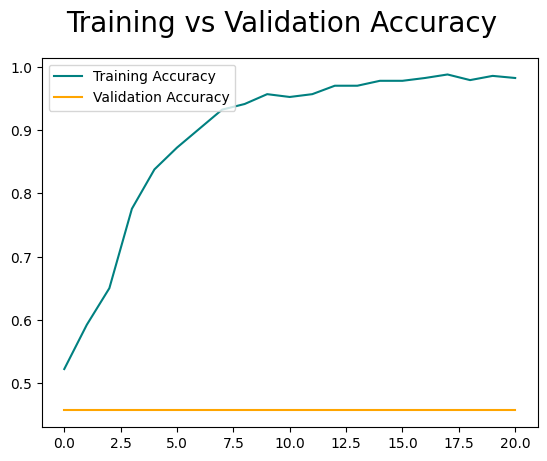

In [44]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training vs Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

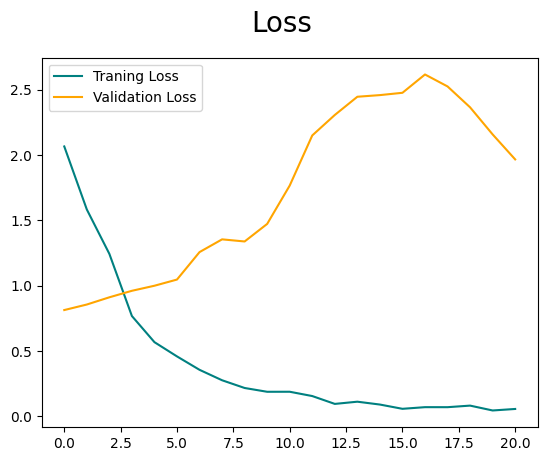

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Traning Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [47]:
import os
model.save(os.path.join('shufflenet_models/karmamobileshuffle', 'overfitting.h5'))

In [48]:
import numpy as np
num_batches = len(test_datas)
batch_size = test_datas.batch_size
total_samples = test_datas.samples

# Calculate the number of steps (batches)
steps = total_samples // batch_size
if total_samples % batch_size != 0:
    steps += 1  # If there are remaining samples, add one more step

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for step in range(steps):
    X, y = next(test_datas)
    yhat = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(np.argmax(yhat, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='binary') 

recall = recall_score(y_true, y_pred, average='binary')  

f1 = f1_score(y_true, y_pred, average='binary')  

cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.45384615384615384
Precision: 0.45384615384615384
Recall: 1.0
F1 Score: 0.6243386243386243
Confusion Matrix:
[[ 0 71]
 [ 0 59]]


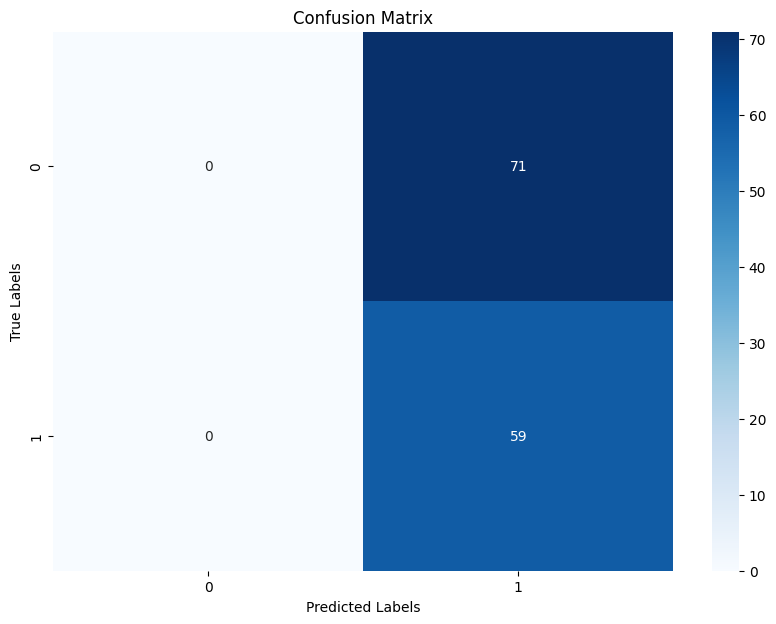

In [51]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()